## Tweet Analysis
The following Notebook demonstrates the data processing capabilities of Spark with respect to analyzing data from Twitter. 
### Pre-Requisites
* Tweets collected using the collect_tweets.py scripts into a json file stored locally or in HDFS
* Anaconda distribution of Python 2.7
* PySpark 2.0

In [1]:
# Initialize spark sessions
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession \
    .builder \
    .appName("TweetAnalysis") \
    .getOrCreate()

### Basic Tweet Processing
 * Read tweets file into dataframe
 * Extract relevant tweet data (retweeted/favorited/quoted, text, user, hashtags, mentions etc.)
 * Extract relevant user data (name, description, location, followers, etc.)

In [2]:
# Read in a file for testing and store it into a table for SQL processing
file = 'data/*.json'
tweets_json = spark.read.json(file)
#%a %b %d %H:%M:%S +0000 %Y' Wed Aug 27 13:08:45 +0000 2008)
tweets_json.createOrReplaceTempView('raw_tweets')
tweets_json.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

In [3]:
# Extract some relevant data about the tweet
columns = ['created_at',
           'entities.hashtags.text as hashtags',
           'entities.urls.expanded_url as url_mentions',
           'entities.user_mentions.id as user_mention_ids',
           'entities.user_mentions.screen_name as user_mention_names',
           'extended_tweet.full_text',
           'favorite_count',
           'favorited',
           'coordinates.coordinates',
           'id',
           'in_reply_to_screen_name',
           'in_reply_to_status_id',
           'in_reply_to_user_id',
           'lang',
           'is_quote_status',
           'quoted_status_id',
           #'quoted_status',
           'place.bounding_box as place_bounding_box',
           'place.country',
           'place',
           'retweet_count',
           'retweeted',
           'retweeted_status.id as retweeted_status_id',
           'text',
           'source',
           'user.id as user_id',
           'user.screen_name as user_name']
tweets_raw = spark.sql('select ' + ','.join(columns) + ' from raw_tweets')
tweets_raw.count()

# Also get the tweet information from original tweets that were retweeted or quoted
columns.remove('retweeted_status.id as retweeted_status_id')
columns.insert(21,'0 as retweeted_status_id')
spark.sql('select retweeted_status.* from raw_tweets').createOrReplaceTempView('raw_rt_tweets')
spark.sql('select quoted_status.* from raw_tweets').createOrReplaceTempView('raw_qt_tweets')
tweets_rt = spark.sql('select ' + ','.join(columns) + ' from raw_rt_tweets')
tweets_qt = spark.sql('select ' + ','.join(columns) + ' from raw_qt_tweets')

# Union all the different types of tweets (note there are some with null create times - filter these out)
tweets_raw = tweets_raw.union(tweets_rt).union(tweets_qt)
print('Total raw tweets: ' + str(tweets_raw.count()))

Total raw tweets: 822261


In [4]:
# Data clean up
tweets_raw = tweets_raw.filter(col('created_at').isNotNull())\
    .withColumn('is_retweet_status', col('retweeted_status_id').isNotNull())\
    .withColumn('is_reply_status', col('in_reply_to_status_id').isNotNull())\
    .distinct()

# We need to make the create_at column into a timestamp for time-series analysis
import datetime
from pytz import timezone, utc
from pyspark.sql.types import TimestampType, ArrayType, StringType
from pyspark.sql.functions import udf, lower
from pyspark.sql import Window

# Convert hashtags to lowercase
def f(hashtag_array):
    return [x.lower() for x in hashtag_array]

createdAtToTimestamp = udf(f, TimestampType())
arrayLowerCase = udf(f, ArrayType(StringType()))

# Data cleanup
# - convert timesetamp string to EST formatted timestamp
# - remove duplicate tweets (ie. retweeted tweets will show up more than once)
# - add columns to indicate if tweet is original, retweet, or reply
# - convert hashtags, mentions and user_names to lowercase
tweets = tweets_raw.filter(tweets_raw.created_at.isNotNull())\
    .withColumn('created_at', unix_timestamp(tweets_raw.created_at, 'EEE MMM dd HH:mm:ss +0000 yyyy'))\
    .withColumn('created_at', from_unixtime('created_at','YYYY-MM-dd HH:mm:ss'))\
    .withColumn('created_at', from_utc_timestamp('created_at', 'EST'))\
    .withColumn('rn', row_number().over(Window.partitionBy('id').orderBy(col('created_at').desc())))\
                .where(col('rn') == 1).drop('rn')\
    .withColumn('is_retweet_status', col('retweeted_status_id').isNotNull())\
    .withColumn('is_reply_status', col('in_reply_to_status_id').isNotNull())\
    .withColumn('hashtags', arrayLowerCase(tweets_raw.hashtags))\
    .withColumn('user_mention_names', arrayLowerCase(tweets_raw.user_mention_names))\
    .withColumn('user_name', lower(tweets_raw.user_name))
    
# Register as a view for Spark SQL
tweets.persist()
print('Total clean tweets: ' + str(tweets.count()))

Total clean tweets: 282487


### Basic Analysis of Tweets
* Top 20 hashtags by tweet
* Top 20 users mentioned (by @user) in tweets about #CyberMonday and #BlackFriday
* Users making tweets about @Amazon and #CyberMonday
* Total interactions (retweets, replies, quotes) by brand tracked

In [5]:
# Common plotting libraries
%matplotlib notebook
import matplotlib.pyplot as plt # side-stepping mpl backend
import matplotlib.gridspec as gridspec # subplots
import pandas

<IPython.core.display.Javascript object>


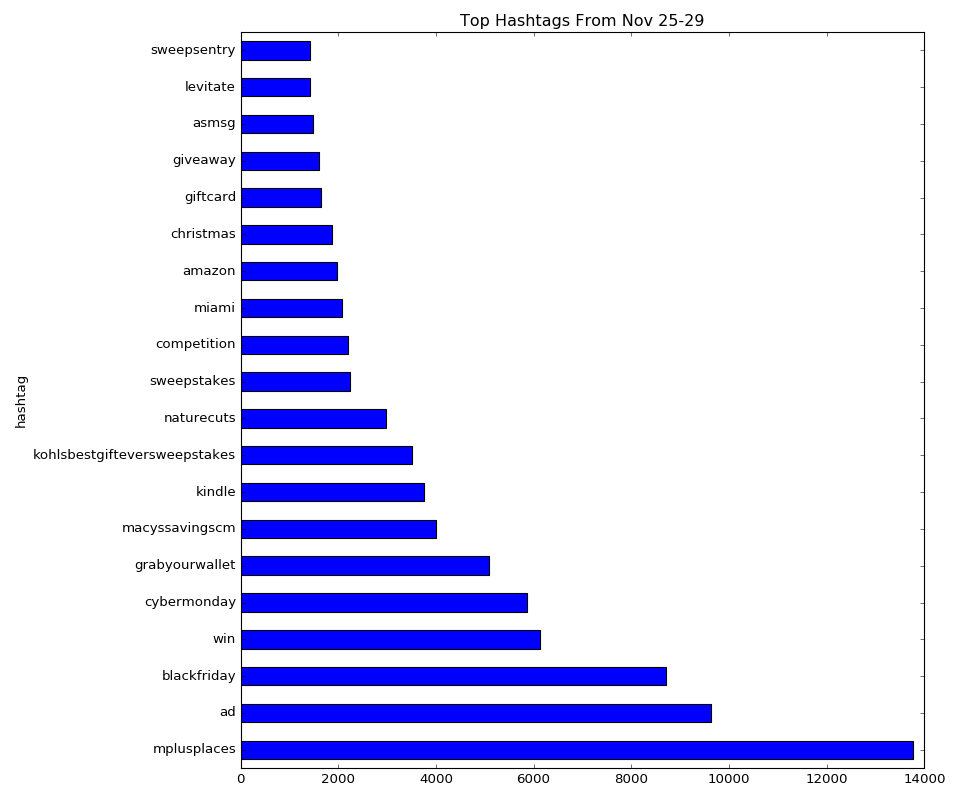

In [8]:
# Get the top 20 hashtags and plot them
from pyspark.sql.functions import explode, lower
hashtags = tweets.select(explode(tweets.hashtags).alias('hashtag'))\
    .groupby('hashtag').count()\
    .orderBy('count', ascending=False).limit(20)
hashtag_pd = hashtags.toPandas()

hashtag_pd.plot(kind='barh', x='hashtag', y='count',
                title='Top Hashtags From Nov 25-29', legend=False, figsize=(12,10))
plt.tight_layout()

<IPython.core.display.Javascript object>


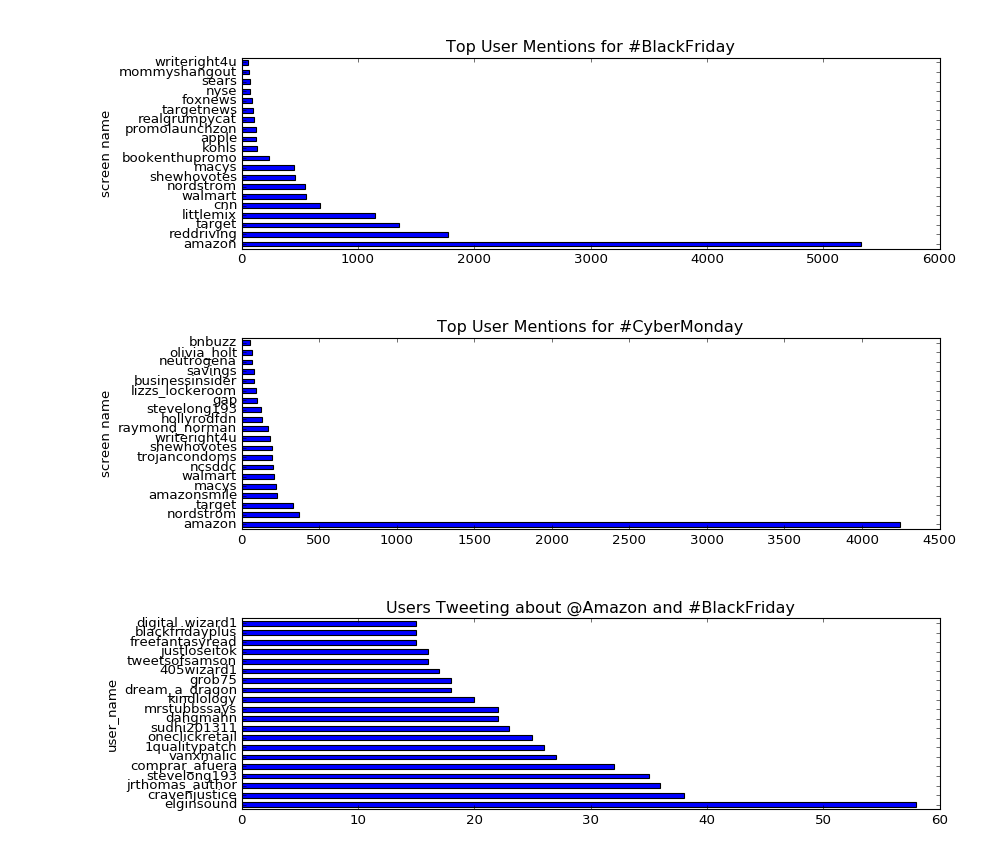

In [9]:
# Top User Mentions for #BlackFriday and #CyberMonday
from pyspark.sql.functions import array_contains, explode, lower
bf_mentions = tweets.filter(array_contains(tweets.hashtags, 'blackfriday'))\
    .select(explode('user_mention_names').alias('screen name'))\
    .groupby('screen name')\
    .count()\
    .orderBy('count', ascending=False)\
    .limit(20)

cyber_mentions = tweets.filter(array_contains(tweets.hashtags, 'cybermonday'))\
    .select(explode('user_mention_names').alias('screen name'))\
    .groupby('screen name')\
    .count()\
    .orderBy('count', ascending=False)\
    .limit(20)

# Top users tweeting about #BlackFriday and @Amazon
users_tweeting = tweets.filter(array_contains(tweets.hashtags, 'blackfriday'))\
    .filter(array_contains('user_mention_names', 'amazon'))\
    .select('user_name', 'id')\
    .groupby('user_name')\
    .count()\
    .orderBy('count', ascending=False)\
    .limit(20)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
bf_mentions.toPandas().plot(kind='barh',
                            ax=ax1,
                            x='screen name', 
                            y='count', 
                            title='Top User Mentions for #BlackFriday', 
                            legend=False)

cyber_mentions.toPandas().plot(kind='barh',
                               ax=ax2,
                               x='screen name', 
                               y='count', 
                               title='Top User Mentions for #CyberMonday', 
                               legend=False)

users_tweeting.toPandas().plot(kind='barh', 
                               ax=ax3,
                               x='user_name', 
                               y='count', 
                               title='Users Tweeting about @Amazon and #BlackFriday', 
                               legend=False)
plt.tight_layout()

<IPython.core.display.Javascript object>


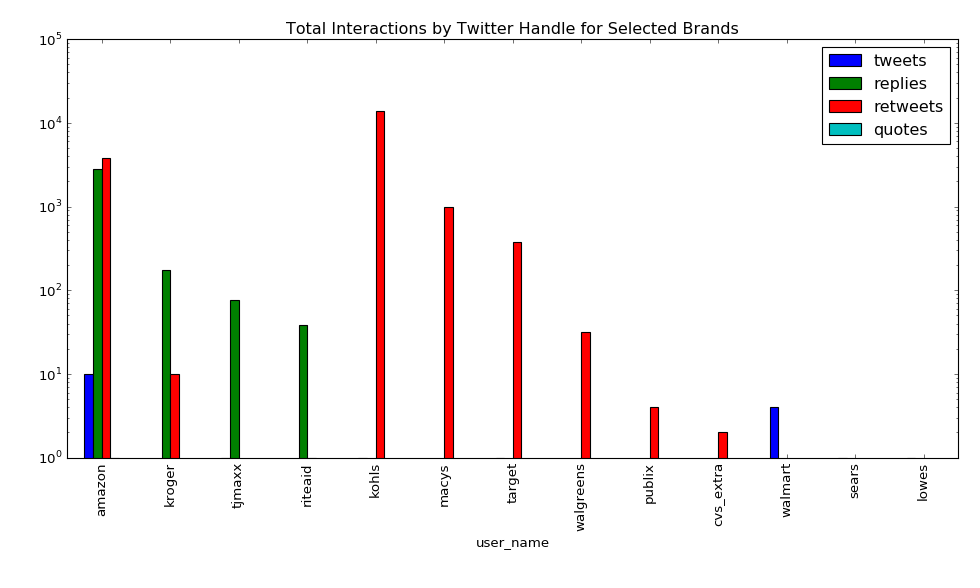

In [10]:
from pyspark.sql.functions import *

# Replies by User Name
replies = tweets.filter(tweets.in_reply_to_user_id.isNotNull())\
          .select(tweets.in_reply_to_screen_name.alias('rp_user_name'))\
          .groupBy('rp_user_name')\
          .count()\
          .withColumnRenamed('count','replies')

# Retweets by User Name
retweets = tweets.filter(tweets.retweet_count>0)\
    .select(tweets.user_name.alias('rt_user_name'), tweets.retweet_count)\
    .groupBy('rt_user_name')\
    .agg(sum(tweets.retweet_count).alias('retweets'))

# Quotes by User Name
quotes = tweets.filter(tweets.quoted_status_id.isNotNull())\
    .select(tweets.user_name.alias('qt_user_name'))\
    .groupBy('qt_user_name')\
    .count()\
    .withColumnRenamed('count','quotes')

    
# Original Tweets by User Name
original = tweets.filter(tweets.in_reply_to_user_id.isNull())\
    .filter(tweets.retweet_count==0)\
    .filter(tweets.quoted_status_id.isNull())\
    .select(tweets.user_name.alias('o_user_name'))\
    .groupBy('o_user_name')\
    .count()\
    .withColumnRenamed('count','tweets')

all_user_names = replies.select(replies.rp_user_name.alias('user_name'))\
    .union(quotes.select(quotes.qt_user_name.alias('user_name')))\
    .union(retweets.select(retweets.rt_user_name.alias('user_name')))\
    .union(original.select(original.o_user_name.alias('user_name')))\
    .distinct()

# Join all together into a single dataframe
interactions = all_user_names.join(replies, all_user_names.user_name==replies.rp_user_name, 'left')\
    .join(retweets, all_user_names.user_name==retweets.rt_user_name, 'left')\
    .join(quotes, all_user_names.user_name==quotes.qt_user_name, 'left')\
    .join(original, all_user_names.user_name==original.o_user_name, 'left')\
    .filter("user_name in \
                ('walmart', 'costco', 'kroger', 'walgreens', 'target', 'amazon', 'cvs_extra',\
                 'lowes', 'safeway', 'sears', 'publix', 'tjmaxx', 'macys', 'riteaid', 'apple', 'kohls')")\
    .select(all_user_names.user_name, 
            original.tweets,
            replies.replies, 
            retweets.retweets,
            quotes.quotes)\
    .fillna(0)\
    .orderBy(replies.replies, 
             retweets.retweets,
             quotes.quotes,
             original.tweets,
             ascending=False)

interactions.toPandas().plot.bar(x='user_name', logy=True,
                                 title='Total Interactions by Twitter Handle for Selected Brands')
plt.tight_layout()

### MLlib
* nGram analysis of tweets
* LDA clustering of tweets

<IPython.core.display.Javascript object>


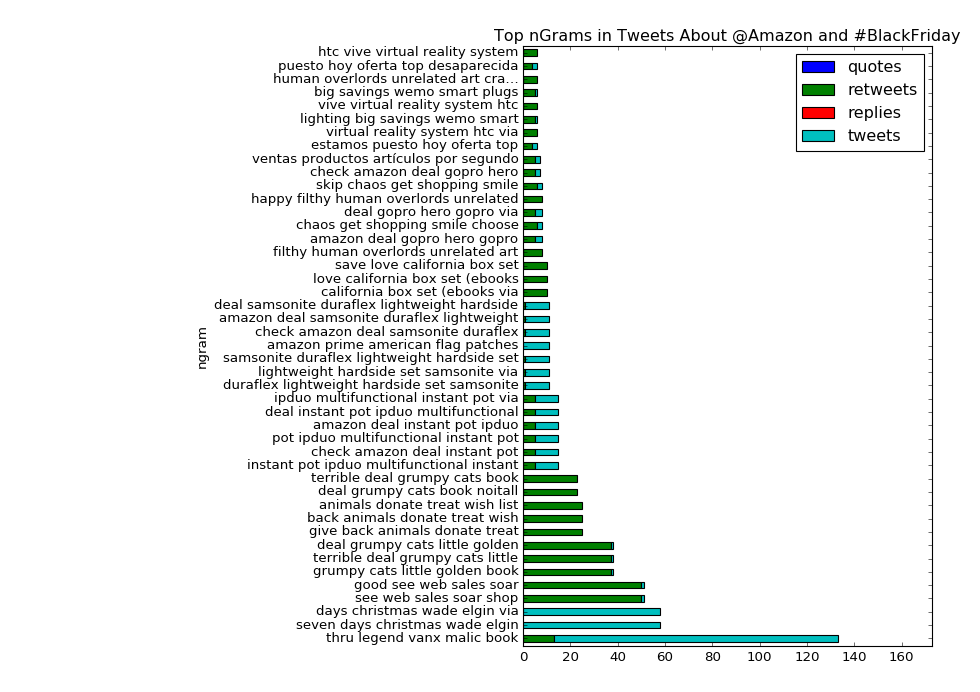

In [6]:
# Understand the word combinations (ngrams) in for a set of tweetsff
from pyspark.sql.functions import *
import re

# UDF to clean the tweet
def f(tweet):
    # Lower Case
    tweet = tweet.lower()
    # Remove URLs (we already capture this)
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', tweet)
    # Remove User Mentions (we already capture this)
    tweet = re.sub('@[^\s]+', '', tweet)
    # Remove hashtags (we already capture this)
    tweet = re.sub(r'#([^\s]+)', '', tweet)
    # Remove punctuation
    tweet = re.sub(r'[\'"?,.!\-&\*\$\%=;:]','', tweet)
    # Remove any numbers
    tweet = re.sub('[0-9]+[^\s]*', '', tweet)
    # &amp;
    tweet = re.sub(r'\bamp([^\s]*)',' ',tweet)
    # Remove 'RT' (already capture this)
    tweet = re.sub(r'\brt([^\s]*)', ' ', tweet)
    # Remove extra spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    return tweet
cleanTweet = udf(f, StringType())

# Extract the cleaned tweet text for tweets mentioning #cybermonday and @amazon
tweets_text = tweets.filter(array_contains(tweets.hashtags, 'blackfriday'))\
    .filter(array_contains('user_mention_names', 'amazon'))\
    .withColumn('fulltext', when(tweets.full_text.isNull(), tweets.text)\
                            .otherwise(tweets.full_text).alias('fulltext'))\
    .withColumn('fulltext', cleanTweet('fulltext'))

from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, NGram

# Tokenize the text into words
tokenizer = RegexTokenizer(inputCol="fulltext", outputCol="raw_words", minTokenLength=3)
tweets_tokenized = tokenizer.transform(tweets_text)

# Remove stop words (ie. I, they, wont etc.)
stop_words = spark.read.text('stop_words.txt').rdd.map(lambda r: r[0]).collect()
sw_remover = StopWordsRemover(inputCol='raw_words', outputCol='words')#, stopWords=stop_words)
tweets_wo_sw = sw_remover.transform(tweets_tokenized)

# Convert remaining words into ngrams
ngrammer = NGram(inputCol="words", outputCol="ngrams", n=5)
tweets_ngrams = ngrammer.transform(tweets_wo_sw)

# Plot the top 50 ngrams 
tweets_ngrams.select(explode('ngrams').alias('ngram'), 
                     tweets_ngrams.is_quote_status,
                     tweets_ngrams.is_retweet_status,
                     tweets_ngrams.is_reply_status)\
    .groupBy('ngram')\
    .agg(count('*').alias('count'),
         sum(tweets_ngrams.is_quote_status.cast('integer')).alias('quotes'),
         sum(tweets_ngrams.is_retweet_status.cast('integer')).alias('retweets'),
         sum(tweets_ngrams.is_reply_status.cast('integer')).alias('replies'))\
    .withColumn('tweets', col('count')-col('quotes')-col('retweets')-col('replies'))\
    .orderBy('count', ascending=False)\
    .limit(50)\
    .toPandas().drop('count',1)\
    .plot(kind='barh', stacked=True, x='ngram', 
          title='Top nGrams in Tweets About @Amazon and #BlackFriday')
plt.tight_layout()

In [29]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.clustering import LDA

cv_model = CountVectorizer(inputCol='words', outputCol='features', vocabSize=10000)\
    .fit(tweets_wo_sw)

count_vectors = cv_model.transform(tweets_wo_sw)\
    .select('id','features')

lda = LDA().setK(5).setMaxIter(100)\
    .fit(count_vectors)

topics = lda.describeTopics(10)

# Show the result
print("The topics described by their top-weighted terms:")
vocab_array = cv_model.vocabulary
for topic in topics.collect():
    print('Topic %d' %topic.topic)
    #print(' Terms ' + str(topic.termIndices))
    #print(' Weights ' + str(topic.termWeights))
    for idx, termIndex in enumerate(topic.termIndices):
        print(" %s:%f" %(vocab_array[termIndex], topic.termWeights[idx]))

#topics.show(truncate=False)

# Shows the result
transformed = lda.transform(count_vectors)
#transformed.show(truncate=False)

The topics described by their top-weighted terms:
Topic 0
 black:0.034944
 deals:0.031783
 list:0.027077
 best:0.022097
 wish:0.018464
Topic 1
 book:0.108384
 thru:0.079554
 legend:0.073987
 malic:0.073011
 vanx:0.073005
Topic 2
 holiday:0.041848
 celebrate:0.031260
 tradition:0.031257
 sacred:0.031255
 today:0.025826
Topic 3
 via:0.027929
 aquafree:0.012806
 save:0.012692
 waterproof:0.011749
 charity:0.010851
Topic 4
 thru:0.050613
 daze:0.050588
 trigon:0.050587
 amazon:0.026007
 prime:0.022425
Topic 5
 deals:0.079584
 great:0.032660
 sale:0.030978
 number:0.030643
 games…:0.028390
Topic 6
 via:0.139293
 christmas:0.032747
 days:0.026244
 elgin:0.025173
 wade:0.025172
Topic 7
 bag:0.107527
 left:0.107011
 days:0.106971
 couple:0.106843
 miss:0.106782
Topic 8
 chance:0.208226
 time:0.207401
 follow:0.207184
 check:0.048246
 deal:0.028068
Topic 9
 shop:0.062908
 shopping:0.027963
 good:0.027721
 sales:0.027273
 get:0.023382


In [171]:
# Extract some relevant data about the user who made the tweet (and timezone-ify like we did with the tweets)
columns = ['user.id',
           'user.created_at',
           'user.description',
           'user.favourites_count',
           'user.followers_count',
           'user.friends_count',
           'user.geo_enabled',
           'user.lang',
           'user.listed_count',
           'user.location',
           'user.name',
           'user.screen_name',
           'user.statuses_count',
           'user.url',
           'user.time_zone',
           'user.verified']
users_raw = spark.sql('select ' + ','.join(columns) + ' from raw_tweets').dropDuplicates()

# Also get the user information from original tweets that were retweeted or quoted
spark.sql('select retweeted_status.* from raw_tweets').createOrReplaceTempView('raw_rt_tweets')
spark.sql('select quoted_status.* from raw_tweets').createOrReplaceTempView('raw_qt_tweets')
users_rt = spark.sql('select ' + ','.join(columns) + ' from raw_rt_tweets').distinct()
users_qt = spark.sql('select ' + ','.join(columns) + ' from raw_qt_tweets').distinct()
users = users_raw.union(users_rt).union(users_qt)\
    .withColumn('screen_name', lower(users_raw.screen_name))\
    .filter(col('created_at').isNotNull())\
    .distinct()

# Change create_at to a timestamp format, convert screen name to lowercase and store dataframe as a view
users = users.withColumn('created_at', createdAtToTimestamp(users.created_at))
users.persist()
print('Total Users: ' + str(users.count()))

DataFrame[id: bigint, created_at: timestamp, description: string, favourites_count: bigint, followers_count: bigint, friends_count: bigint, geo_enabled: boolean, lang: string, listed_count: bigint, location: string, name: string, screen_name: string, statuses_count: bigint, url: string, time_zone: string, verified: boolean]